In [2]:
import requests
from scipy.stats import norm
import numpy as np
from datetime import datetime, timedelta,timezone
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
import deribit_data as dm
btc_data = dm.Options("BTC")

# Get realised historical volatility
vol = btc_data.get_hist_vol(save_csv=True)
vol

ModuleNotFoundError: No module named 'deribit_data'

In [105]:
vol =pd.read_csv('btc_hist_vol.csv')
vol['date'] = pd.to_datetime(vol['date']).dt.strftime('%Y/%m/%d %H:%M')

In [138]:
df = pd.read_csv('BTCUSDT-1h-2024-04.csv')
df['Date'] = pd.to_datetime(df['Date'], format="%Y/%m/%d %H:%M", errors='coerce')

# Define the period and dates as specified
period = 15
start_date = pd.to_datetime('2024-04-20 12:00:00')
end_date = start_date + pd.Timedelta(days=period)

# Filter the dataframe within the date range
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
df = df.sort_values(by='Date', ascending=True)
df = df.reset_index(drop=True)

df

,Date,Open,Close,High,Low,Volume BTC,tradecount
0,2024-04-20 12:00:00,63538.6,63688.7,63900.0,63525.3,6455.652,113688
1,2024-04-20 13:00:00,63688.7,63790.8,63916.0,63537.3,5018.383,98437
2,2024-04-20 14:00:00,63790.8,63846.5,64034.1,63768.0,5066.921,103675
3,2024-04-20 15:00:00,63846.4,63906.0,63963.6,63703.2,3993.655,82293
4,2024-04-20 16:00:00,63905.9,64771.0,64940.0,63758.0,19737.277,264255
...,...,...,...,...,...,...,...
356,2024-05-05 08:00:00,63345.1,63697.1,63932.4,63321.9,11298.688,152633
357,2024-05-05 09:00:00,63697.1,63639.7,63900.0,63505.7,8100.912,151946
358,2024-05-05 10:00:00,63639.6,63638.3,63719.4,63521.1,3869.077,82650
359,2024-05-05 11:00:00,63638.3,63663.9,63820.0,63523.0,3451.611,68336


In [139]:
df.columns

Index(['Date', 'Open', 'Close', 'High', 'Low', 'Volume BTC', 'tradecount'], dtype='object')

In [140]:
# Determine the date ranges for both datasets
main_data_range = (df['Date'].min(), df['Date'].max())
volatility_data_range = (vol['date'].min(), vol['date'].max())

main_data_range, volatility_data_range

((Timestamp('2024-04-20 12:00:00'), Timestamp('2024-05-05 12:00:00')),
 (Timestamp('2024-04-20 12:00:00'), Timestamp('2024-05-06 10:00:00')))

In [141]:
# Assuming df and vol are your dataframes
df['Date'] = pd.to_datetime(df['Date'])
vol['date'] = pd.to_datetime(vol['date'])

# Now perform the merge
df = pd.merge(df, vol, left_on='Date', right_on='date', how='inner')

# Drop the redundant 'date' column after merge
df.drop(columns='date', inplace=True)

df

,Date,Open,Close,High,Low,Volume BTC,tradecount,btc_hist_vol
0,2024-04-20 12:00:00,63538.6,63688.7,63900.0,63525.3,6455.652,113688,67.836106
1,2024-04-20 13:00:00,63688.7,63790.8,63916.0,63537.3,5018.383,98437,67.716641
2,2024-04-20 14:00:00,63790.8,63846.5,64034.1,63768.0,5066.921,103675,67.650475
3,2024-04-20 15:00:00,63846.4,63906.0,63963.6,63703.2,3993.655,82293,67.486604
4,2024-04-20 16:00:00,63905.9,64771.0,64940.0,63758.0,19737.277,264255,67.323414
...,...,...,...,...,...,...,...,...
356,2024-05-05 08:00:00,63345.1,63697.1,63932.4,63321.9,11298.688,152633,54.795853
357,2024-05-05 09:00:00,63697.1,63639.7,63900.0,63505.7,8100.912,151946,54.860806
358,2024-05-05 10:00:00,63639.6,63638.3,63719.4,63521.1,3869.077,82650,54.831801
359,2024-05-05 11:00:00,63638.3,63663.9,63820.0,63523.0,3451.611,68336,54.823909


In [142]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Ensure the 'Open' and 'volatility' columns are floats
df['Open'] = df['Open'].astype(float)
df['volatility'] = (df['btc_hist_vol'] / 100).astype(float)

def calculate_delta(spot, strike, time_to_maturity, risk_free_rate, volatility, option_type='call'):
    if time_to_maturity <= 0:
        return 0
    d1 = (np.log(spot / strike) + (risk_free_rate + 0.5 * volatility**2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    return norm.cdf(d1) if option_type == 'call' else -norm.cdf(-d1)

strike = 65000
time_to_maturity = 30 / 365
current_hedge_position = 0
hedge_changes = []
transaction_costs = []
position_value_changes = []
current_positions = []

previous_spot = df['Open'].iloc[0]

for index, row in df.iterrows():
    spot = row['Open']
    current_volatility = row['volatility']
    delta = calculate_delta(spot, strike, time_to_maturity, risk_free_rate, current_volatility, 'call')
    
    new_hedge_position = delta
    hedge_change = new_hedge_position - current_hedge_position
    
    transaction_cost = abs(hedge_change) * spot * 0.001
    value_change = (spot - previous_spot) * current_hedge_position
    
    print(f"Delta: {delta}, Hedge Change: {hedge_change}, Transaction Cost: {transaction_cost}, Value Change: {value_change}")

    transaction_costs.append(transaction_cost)
    position_value_changes.append(value_change)
    hedge_changes.append(hedge_change)
    current_positions.append(new_hedge_position)
    
    previous_spot = spot
    current_hedge_position = new_hedge_position
    time_to_maturity -= 1 / (365 * 24)
    if time_to_maturity <= 0:
        break

df['Hedge Change'] = hedge_changes
df['Transaction Cost'] = transaction_costs
df['Position Value Change'] = position_value_changes
df['Current Hedge Position'] = current_positions

print(df[['Date', 'Open', 'Hedge Change', 'Transaction Cost', 'Position Value Change', 'Current Hedge Position']])

Delta: 0.5005767581572769, Hedge Change: 0.5005767581572769, Transaction Cost: 31.80594640585195, Value Change: 0.0
Delta: 0.5052277513866237, Hedge Change: 0.0046509932293468115, Transaction Cost: 0.2962157124859003, Value Change: 75.13657139940653
Delta: 0.508394233259144, Hedge Change: 0.0031664818725203325, Transaction Cost: 0.20199241183357003, Value Change: 51.58375341657722
Delta: 0.5099672025896741, Hedge Change: 0.001572969330530083, Transaction Cost: 0.1004284290647559, Value Change: 28.266719369207667
Delta: 0.5116763601402211, Hedge Change: 0.0017091575505470136, Transaction Cost: 0.10922525150950241, Value Change: 30.34304855408561
Delta: 0.5396102364192722, Hedge Change: 0.027933876279051084, Transaction Cost: 1.8093051004704177, Value Change: 442.6512191573045
Delta: 0.5375821477876316, Hedge Change: -0.002028088631640612, Transaction Cost: 0.13123518164710607, Value Change: -33.56375670527716
Delta: 0.5520701808992283, Hedge Change: 0.014488033111596743, Transaction Cos

In [143]:
df

,Date,Open,Close,High,Low,Volume BTC,tradecount,btc_hist_vol,volatility,Hedge Change,Transaction Cost,Position Value Change,Current Hedge Position
0,2024-04-20 12:00:00,63538.6,63688.7,63900.0,63525.3,6455.652,113688,67.836106,0.678361,0.500577,31.805946,0.000000,0.500577
1,2024-04-20 13:00:00,63688.7,63790.8,63916.0,63537.3,5018.383,98437,67.716641,0.677166,0.004651,0.296216,75.136571,0.505228
2,2024-04-20 14:00:00,63790.8,63846.5,64034.1,63768.0,5066.921,103675,67.650475,0.676505,0.003166,0.201992,51.583753,0.508394
3,2024-04-20 15:00:00,63846.4,63906.0,63963.6,63703.2,3993.655,82293,67.486604,0.674866,0.001573,0.100428,28.266719,0.509967
4,2024-04-20 16:00:00,63905.9,64771.0,64940.0,63758.0,19737.277,264255,67.323414,0.673234,0.001709,0.109225,30.343049,0.511676
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2024-05-05 08:00:00,63345.1,63697.1,63932.4,63321.9,11298.688,152633,54.795853,0.547959,0.008764,0.555178,68.781458,0.437844
357,2024-05-05 09:00:00,63697.1,63639.7,63900.0,63505.7,8100.912,151946,54.860806,0.548608,0.019582,1.247346,154.121062,0.457426
358,2024-05-05 10:00:00,63639.6,63638.3,63719.4,63521.1,3869.077,82650,54.831801,0.548318,-0.003398,0.216259,-26.302018,0.454028
359,2024-05-05 11:00:00,63638.3,63663.9,63820.0,63523.0,3451.611,68336,54.823909,0.548239,-0.000230,0.014666,-0.590237,0.453798


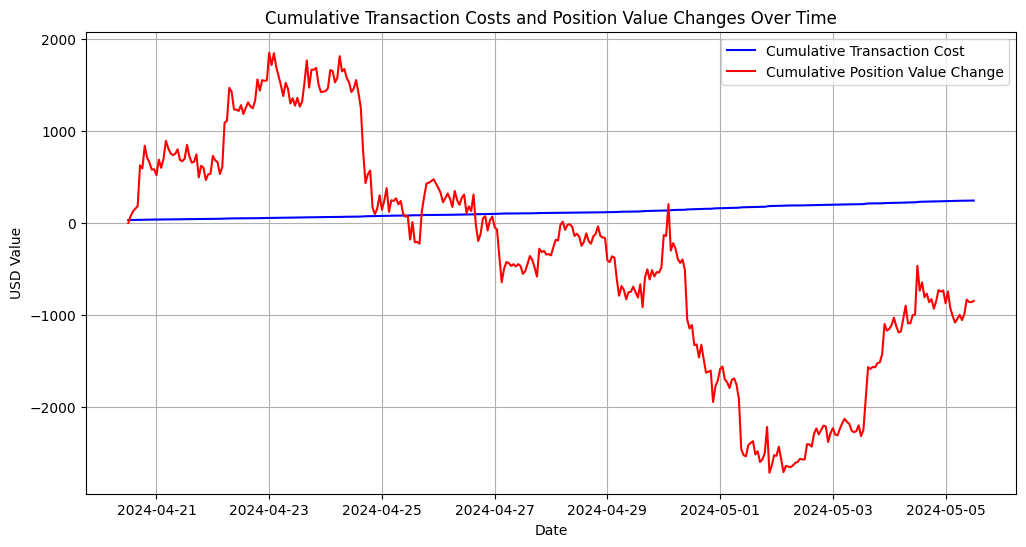

In [145]:
import matplotlib.pyplot as plt

# Calculate cumulative sums
df['Cumulative Transaction Cost'] = df['Transaction Cost'].cumsum()
df['Cumulative Position Value Change'] = df['Position Value Change'].cumsum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Cumulative Transaction Cost'], label='Cumulative Transaction Cost', color='blue')
plt.plot(df['Date'], df['Cumulative Position Value Change'], label='Cumulative Position Value Change', color='red')

plt.title('Cumulative Transaction Costs and Position Value Changes Over Time')
plt.xlabel('Date')
plt.ylabel('USD Value')
plt.legend()
plt.grid(True)
plt.show()

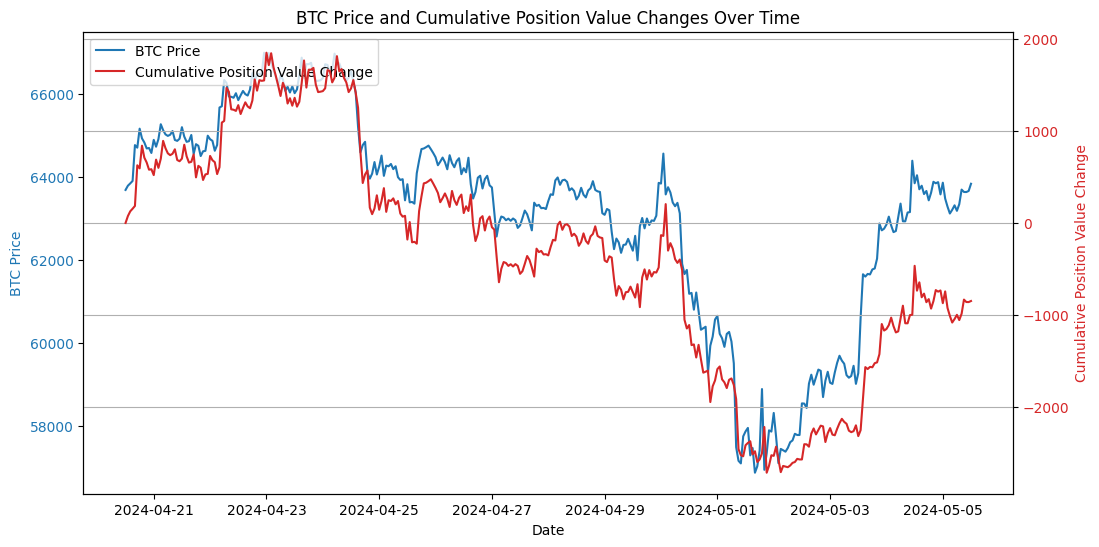

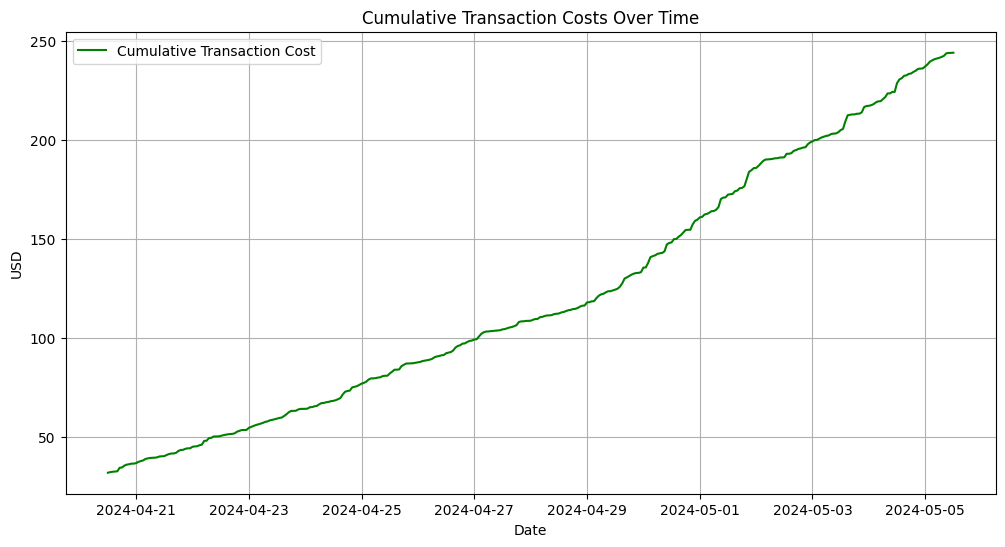

In [146]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price', color=color)
ax1.plot(df['Date'], df['Close'], color=color, label='BTC Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Cumulative Position Value Change', color=color)
ax2.plot(df['Date'], df['Cumulative Position Value Change'], color=color, label='Cumulative Position Value Change')
ax2.tick_params(axis='y', labelcolor=color)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('BTC Price and Cumulative Position Value Changes Over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Cumulative Transaction Cost'], label='Cumulative Transaction Cost', color='green')
plt.title('Cumulative Transaction Costs Over Time')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.show()